In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import gensim
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from textblob import TextBlob, Word
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
%matplotlib inline

In [2]:
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models, matutils


Importing all Presidential speeches and appending them to a dataframe

In [3]:
from os import path
from pathlib import Path
import os
import glob
from collections import defaultdict
root=r'C:\Users\hartg\Desktop\Professional_Projects\Professional-Projects\MSF_Case_Study\Corpus of Presential Speeches\combined'
files=os.listdir(root)

#load speeches into a list

docs=list()
for file in files:
    with open(path.join(root,file),'r',encoding='utf-8') as fd:
        txt=fd.read()
        docs.append(txt)

Function that "cleans" the speeches. Re (regular expression) replaces special characters with, in this case, nothing. This will remove the <title=> characters, etc

In [4]:
import re
def clean(doc):
    doc = re.sub(r'[^\w\s]*','',doc)
    doc = re.sub(r'[\s]+', ' ', doc)
    doc = doc.lower().strip()
    return doc

clean the documents associated with the presidential speeches

In [5]:
clean_docs=list()
for doc in docs:
    doc = clean(doc)
    clean_docs.append(doc)

In [6]:
speeches_df=pd.DataFrame(docs)
speeches_df.columns=['text']

In [7]:
speeches_df.head()

,text
0,"<title=""Special Session Message to Congress"">\..."
1,"<title=""Inaugural Address"">\n<date=""March 4, 1..."
2,"<title=""Second Annual Message"">\n<date=""Decemb..."
3,"<title=""Proclamation of Day of Fasting, Humili..."
4,"<title=""Third Annual Message"">\n<date=""Decembe..."


In [8]:
new_df=speeches_df['text'].str.split("=",n=1,expand=True)
new_df.columns=['title_bad','title_actual']
new_df.head()

,title_bad,title_actual
0,<title,"""Special Session Message to Congress"">\n<date=..."
1,<title,"""Inaugural Address"">\n<date=""March 4, 1797"">\n..."
2,<title,"""Second Annual Message"">\n<date=""December 8, 1..."
3,<title,"""Proclamation of Day of Fasting, Humiliation a..."
4,<title,"""Third Annual Message"">\n<date=""December 3, 17..."


In [9]:
new_df2=new_df['title_actual'].str.split("=",n=1,expand=True)
new_df2.columns=['title','date_and_text']
new_df2.head()

,title,date_and_text
0,"""Special Session Message to Congress"">\n<date","""May 16, 1797"">\nThe personal inconveniences t..."
1,"""Inaugural Address"">\n<date","""March 4, 1797"">\nWhen it was first perceived,..."
2,"""Second Annual Message"">\n<date","""December 8, 1798"">\nGentlemen of the Senate a..."
3,"""Proclamation of Day of Fasting, Humiliation a...","""March 23, 1798"">\nAs the safety and prosperit..."
4,"""Third Annual Message"">\n<date","""December 3, 1799"">\nIt is with peculiar satis..."


In [10]:
new_df3=new_df2['date_and_text'].str.split(">",n=1,expand=True)
new_df3.columns=['date','text']

In [11]:
new_df3.head()

,date,text
0,"""May 16, 1797""",\nThe personal inconveniences to the members o...
1,"""March 4, 1797""","\nWhen it was first perceived, in early times,..."
2,"""December 8, 1798""",\nGentlemen of the Senate and Gentlemen of the...
3,"""March 23, 1798""",\nAs the safety and prosperity of nations ulti...
4,"""December 3, 1799""",\nIt is with peculiar satisfaction that I meet...


In [12]:
speeches=pd.merge(new_df2,new_df3,left_index=True,right_index=True)

In [13]:
speeches.head()

,title,date_and_text,date,text
0,"""Special Session Message to Congress"">\n<date","""May 16, 1797"">\nThe personal inconveniences t...","""May 16, 1797""",\nThe personal inconveniences to the members o...
1,"""Inaugural Address"">\n<date","""March 4, 1797"">\nWhen it was first perceived,...","""March 4, 1797""","\nWhen it was first perceived, in early times,..."
2,"""Second Annual Message"">\n<date","""December 8, 1798"">\nGentlemen of the Senate a...","""December 8, 1798""",\nGentlemen of the Senate and Gentlemen of the...
3,"""Proclamation of Day of Fasting, Humiliation a...","""March 23, 1798"">\nAs the safety and prosperit...","""March 23, 1798""",\nAs the safety and prosperity of nations ulti...
4,"""Third Annual Message"">\n<date","""December 3, 1799"">\nIt is with peculiar satis...","""December 3, 1799""",\nIt is with peculiar satisfaction that I meet...


In [14]:
speeches.drop(['date_and_text'],axis=1,inplace=True)

In [15]:
speeches['title']=speeches.title.str.replace('>\n<date','',regex=True)
speeches.head()

,title,date,text
0,"""Special Session Message to Congress""","""May 16, 1797""",\nThe personal inconveniences to the members o...
1,"""Inaugural Address""","""March 4, 1797""","\nWhen it was first perceived, in early times,..."
2,"""Second Annual Message""","""December 8, 1798""",\nGentlemen of the Senate and Gentlemen of the...
3,"""Proclamation of Day of Fasting, Humiliation a...","""March 23, 1798""",\nAs the safety and prosperity of nations ulti...
4,"""Third Annual Message""","""December 3, 1799""",\nIt is with peculiar satisfaction that I meet...


In [16]:
speeches['date']=speeches.date.str.replace('"','',regex=True)
speeches.head()

,title,date,text
0,"""Special Session Message to Congress""","May 16, 1797",\nThe personal inconveniences to the members o...
1,"""Inaugural Address""","March 4, 1797","\nWhen it was first perceived, in early times,..."
2,"""Second Annual Message""","December 8, 1798",\nGentlemen of the Senate and Gentlemen of the...
3,"""Proclamation of Day of Fasting, Humiliation a...","March 23, 1798",\nAs the safety and prosperity of nations ulti...
4,"""Third Annual Message""","December 3, 1799",\nIt is with peculiar satisfaction that I meet...


In [17]:
speeches['text']=speeches.text.str.replace("\n",'',regex=True)
speeches.head()

,title,date,text
0,"""Special Session Message to Congress""","May 16, 1797",The personal inconveniences to the members of ...
1,"""Inaugural Address""","March 4, 1797","When it was first perceived, in early times, t..."
2,"""Second Annual Message""","December 8, 1798",Gentlemen of the Senate and Gentlemen of the H...
3,"""Proclamation of Day of Fasting, Humiliation a...","March 23, 1798",As the safety and prosperity of nations ultima...
4,"""Third Annual Message""","December 3, 1799",It is with peculiar satisfaction that I meet t...


Dropping indeces 208,801, and 814 as they were not appropriately transformed upon import

In [18]:
speeches.drop([208,801,814],inplace=True)

In [19]:
speeches['date']=pd.to_datetime(speeches['date'])

In [20]:
speeches.set_index('date',inplace=True)


In [21]:
speeches=speeches.loc['1893':'1969',:]

In [22]:
speeches['text']=speeches['text'].str.lower()

Loading stopwords from NLTK

In [23]:
from nltk.corpus import stopwords

In [24]:
from gensim.parsing.preprocessing import preprocess_string
from gensim.parsing.preprocessing import strip_tags,strip_punctuation,strip_numeric,stem_text
from gensim.parsing.preprocessing import strip_multiple_whitespaces,strip_non_alphanum,remove_stopwords,strip_short
import pattern
import nltk

In [25]:
Filtering=[lambda x: x.lower(),strip_multiple_whitespaces,
          strip_numeric,
          remove_stopwords,
          strip_short]

In [26]:

def preprocess(text):
    result=[]
    for token in preprocess_string(text,Filtering):
        result.append(token)
    return result
speeches['processed_speech']=speeches['text'].map(preprocess)

In [27]:
lemmatizer=nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    return[lemmatizer.lemmatize(w) for w in text]


In [28]:
speeches['processed_speech']=speeches.processed_speech.apply(lemmatize_text)

In [29]:
speeches['bigrams']=speeches.processed_speech.apply(lambda row: list(nltk.ngrams(row,2)))

In [30]:
from gensim import corpora,models,similarities
dictionary=corpora.Dictionary(speeches.processed_speech)

Creating the corpus of documents. Doc2Bow counts the number of occurences of each distinct word and converts the word to an integer word ID. Returns a sparse vector

In [31]:
corpus=[dictionary.doc2bow(text) for text in speeches.processed_speech]

Building a TF-IDF Model (Term Frequency Inverse Document Frequency)

In [32]:
tfidf=models.TfidfModel(corpus)
transformed_tfidf = tfidf[corpus]

LDA (Latent Dirichlet Allocation) on TF-IDF

In [33]:
num_topics=5
%time lda = models.LdaModel(transformed_tfidf,id2word=dictionary,num_topics=num_topics,passes=4,alpha=[.01]*num_topics,eta=[.01]*len(dictionary.keys()))

Wall time: 14.3 s


In [34]:
lda.show_topics()

[(0,
  '0.003*"president.>" + 0.002*"mr." + 0.002*"<q." + 0.002*"think" + 0.002*"vietnam" + 0.002*"president," + 0.001*"communist" + 0.001*"going" + 0.001*"south" + 0.001*"don\'t"'),
 (1,
  '0.002*"law" + 0.001*"business" + 0.001*"gold" + 0.001*"public" + 0.001*"treaty" + 0.001*"federal" + 0.001*"tariff" + 0.001*"government" + 0.001*"congress" + 0.001*"condition"'),
 (2,
  '0.001*"silver" + 0.001*"rome" + 0.001*"korea" + 0.001*"bullion" + 0.000*"seasonal" + 0.000*"gold" + 0.000*"romney" + 0.000*"porto" + 0.000*"northwest" + 0.000*"coinage"'),
 (3,
  '0.001*"vietnam" + 0.001*"huerta" + 0.001*"taft-hartley" + 0.001*"tariff" + 0.001*".%the" + 0.000*"vietnam." + 0.000*"accusation" + 0.000*"soils," + 0.000*"representative" + 0.000*"vietnam,"'),
 (4,
  '0.002*"dominican" + 0.001*"alien" + 0.001*"veteran" + 0.001*"corp" + 0.001*"<mr." + 0.001*"miner" + 0.001*"hawaiian" + 0.001*"immigrant" + 0.001*"oas" + 0.001*"republic."')]

In [35]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis=pyLDAvis.gensim.prepare(lda,corpus,dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.158462 -0.004097       1        1  62.576519
0     -0.036095  0.137918       2        1  37.118267
4     -0.035594 -0.034806       3        1   0.234644
2     -0.048795 -0.058076       4        1   0.041592
3     -0.037977 -0.040937       5        1   0.028973, topic_info=              Term        Freq       Total Category  logprob  loglift
28629      vietnam  405.000000  405.000000  Default  30.0000  30.0000
23323  president.>  645.000000  645.000000  Default  29.0000  29.0000
6069           <q.  542.000000  542.000000  Default  28.0000  28.0000
782         tariff  543.000000  543.000000  Default  27.0000  27.0000
2626           mr.  602.000000  602.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
24        business    0.067105  584.843506   Topic5  -7.8638  -0.9263
23323  president.>    0.066745  645.566406   Topic5  -7.8692  -1.0304
12670        greek    0.060123   82.084999   Topic5  -7.9737   0.9275
1880          cuba    0.062214  329.124786   Topic5  -7.9395  -0.4270
2626           mr.    0.058071  602.144775   Topic5  -8.0084  -1.1000

[350 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
24184      1  0.665002      "face
24184      2  0.332501      "face
37773      1  0.747571  "however,
37773      2  0.373786  "however,
31281      1  0.741853       "ich
...      ...       ...        ...
23303      2  0.370508     year."
17218      1  0.030162       yes,
17218      2  0.965199       yes,
3483       1  0.985271       zone
3483       2  0.017594       zone

[638 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 5, 3, 4])

In [36]:
count = 1
for doc in speeches['processed_speech']:
    vec=dictionary.doc2bow(doc)
    print("Speech # ",count, lda[vec])
    count=count+1

Speech #  1 [(0, 0.19408125), (1, 0.7100545), (4, 0.09576897)]
Speech #  2 [(0, 0.16999938), (1, 0.8299542)]
Speech #  3 [(0, 0.13242634), (1, 0.85570437), (2, 0.011839996)]
Speech #  4 [(0, 0.16385473), (1, 0.8322241)]
Speech #  5 [(0, 0.13604839), (1, 0.81299305), (2, 0.050938115)]
Speech #  6 [(0, 0.2278532), (1, 0.75148964), (4, 0.020646933)]
Speech #  7 [(0, 0.12667574), (1, 0.87328327)]
Speech #  8 [(0, 0.052812632), (1, 0.94707245)]
Speech #  9 [(0, 0.16713464), (1, 0.8318268)]
Speech #  10 [(0, 0.19987789), (1, 0.59203523), (4, 0.20795144)]
Speech #  11 [(0, 0.12562178), (1, 0.8743205)]
Speech #  12 [(0, 0.060123045), (1, 0.8165505), (4, 0.123179115)]
Speech #  13 [(0, 0.16232556), (1, 0.8376682)]
Speech #  14 [(0, 0.04120875), (1, 0.9586639)]
Speech #  15 [(0, 0.21066634), (1, 0.74494857), (3, 0.044235047)]
Speech #  16 [(0, 0.07092256), (1, 0.9289311)]
Speech #  17 [(0, 0.23751888), (1, 0.6767312), (4, 0.08571737)]
Speech #  18 [(0, 0.16976383), (1, 0.82698053)]
Speech #  19 

Speech #  190 [(0, 0.69788724), (1, 0.30209386)]
Speech #  191 [(0, 0.5123831), (1, 0.48031136)]
Speech #  192 [(0, 0.4132411), (1, 0.58667284)]
Speech #  193 [(0, 0.5809015), (1, 0.41901836)]
Speech #  194 [(0, 0.5138602), (1, 0.48612028)]
Speech #  195 [(0, 0.77794003), (1, 0.22203712)]
Speech #  196 [(0, 0.6055582), (1, 0.3944183)]
Speech #  197 [(0, 0.39496726), (1, 0.6050125)]
Speech #  198 [(0, 0.5495432), (1, 0.45038393)]
Speech #  199 [(0, 0.62900263), (1, 0.3709771)]
Speech #  200 [(0, 0.6687684), (1, 0.33120832)]
Speech #  201 [(0, 0.47775295), (1, 0.5222208)]
Speech #  202 [(0, 0.6615175), (1, 0.33846393)]
Speech #  203 [(0, 0.6987474), (1, 0.30114856)]
Speech #  204 [(0, 0.6038059), (1, 0.3960856)]
Speech #  205 [(0, 0.558567), (1, 0.44141498)]
Speech #  206 [(0, 0.63346475), (1, 0.35852247)]
Speech #  207 [(0, 0.24200694), (1, 0.5451661), (4, 0.21262434)]
Speech #  208 [(0, 0.47493196), (1, 0.476566), (4, 0.04847952)]
Speech #  209 [(0, 0.6526658), (1, 0.34437642)]
Speech 

In [37]:
t=0
for i in lda.show_topics(num_topics=num_topics, num_words=5, log=False, formatted=True):
    print ("Topic # ", t , i)
    t = t + 1

Topic #  0 (0, '0.003*"president.>" + 0.002*"mr." + 0.002*"<q." + 0.002*"think" + 0.002*"vietnam"')
Topic #  1 (1, '0.002*"law" + 0.001*"business" + 0.001*"gold" + 0.001*"public" + 0.001*"treaty"')
Topic #  2 (2, '0.001*"silver" + 0.001*"rome" + 0.001*"korea" + 0.001*"bullion" + 0.000*"seasonal"')
Topic #  3 (3, '0.001*"vietnam" + 0.001*"huerta" + 0.001*"taft-hartley" + 0.001*"tariff" + 0.001*".%the"')
Topic #  4 (4, '0.002*"dominican" + 0.001*"alien" + 0.001*"veteran" + 0.001*"corp" + 0.001*"<mr."')


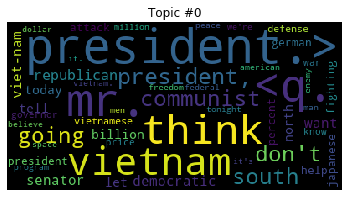

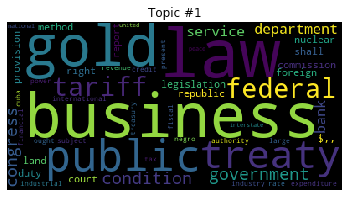

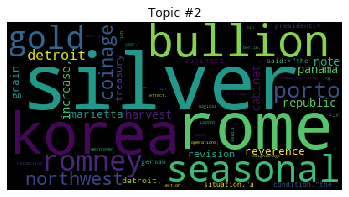

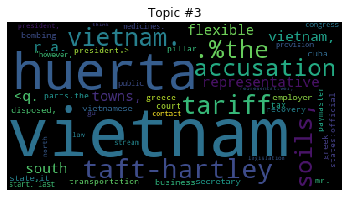

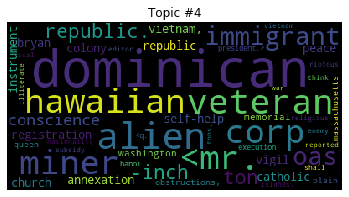

In [38]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
for t in range(lda.num_topics):
    plt.figure()
    plt.imshow(WordCloud().fit_words(dict(lda.show_topic(t,50))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()

In [39]:
topics = [lda[corpus[i]] for i in range(len(speeches))]

def topics_document_to_dataframe(topics_document, num_topics):
    res = pd.DataFrame(columns=range(num_topics))
    for topic_weight in topics_document:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res
document_topic=\
pd.concat([topics_document_to_dataframe(topics_document, num_topics=num_topics) for topics_document in topics]) \
  .reset_index(drop=True).fillna(0)

Text(33.0, 0.5, 'Speech')

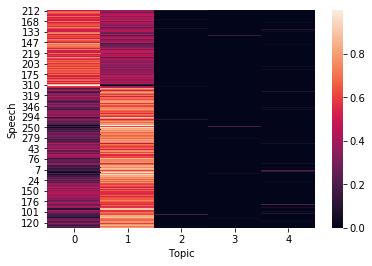

In [40]:
import seaborn as sns
sns.heatmap(document_topic.loc[document_topic.idxmax(axis=1).sort_values().index])
plt.xlabel('Topic')
plt.ylabel('Speech')

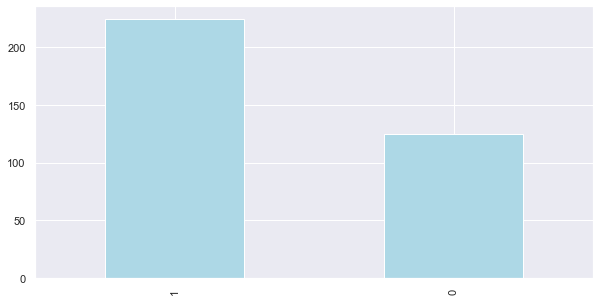

In [41]:
sns.set(rc={'figure.figsize':(10,5)})
document_topic.idxmax(axis=1).value_counts().plot.bar(color='lightblue')